## Setup

In [1]:
import matplotlib.pyplot as plt
from skimage.filters import *
import imutils
import cv2
import numpy as np
import pytesseract
from functools import reduce
from operator import add
import specularity as spc

## Import image

In [50]:
src = cv2.imread("./images/2.png")
src = cv2.cvtColor(src, cv2.COLOR_RGB2BGR)

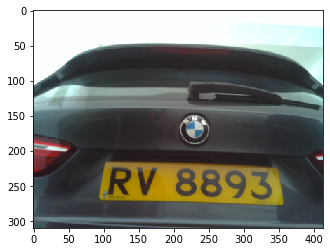

In [51]:
plt.imshow(src)
plt.show()

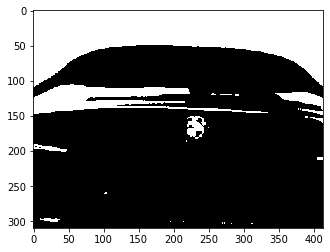

In [52]:
gray_img = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
simg = spc.derive_saturation(src, gray_img).astype(np.int32) # Get distnct black in specularity
spec_mask = spc.check_pixel_specularity(gray_img, simg)
spec_mask = cv2.dilate(spec_mask, np.ones((2,2), np.uint8))

plt.imshow(spec_mask, cmap='gray')
plt.show()


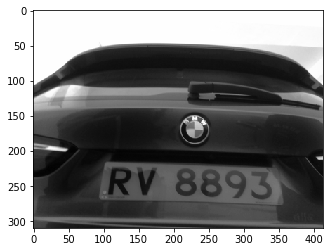

In [53]:
bw = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
plt.imshow(bw, cmap = 'gray')
plt.show()

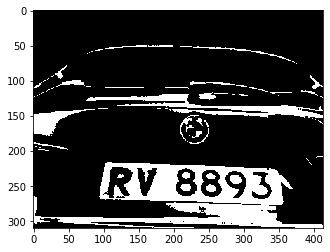

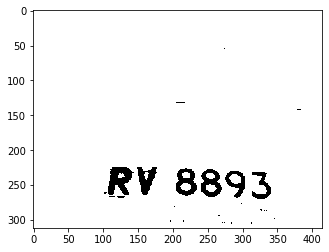

In [60]:
threshold_value = threshold_minimum(bw)
binary_image = (bw > threshold_value).astype(np.uint8)
binary_image = np.logical_and(binary_image, np.logical_not(spec_mask)).astype(np.uint8)
binary_image_white_filled = cv2.copyMakeBorder(binary_image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 0])
mask = cv2.copyMakeBorder(binary_image_white_filled, 1, 1, 1, 1, cv2.BORDER_CONSTANT, 0)
cv2.floodFill(binary_image_white_filled, mask, (0, 0), 255, flags=cv2.FLOODFILL_MASK_ONLY)
binary_image_white_filled = mask[10: -10, 10: -10]
plt.imshow(binary_image, cmap = 'gray')
plt.show()
plt.imshow(binary_image_white_filled, cmap = 'gray')
plt.show()

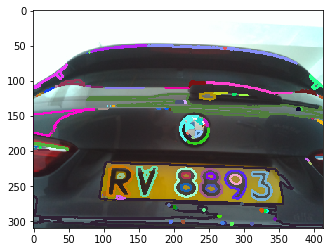

In [55]:
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
src_copy = src.copy()
for contour in contours:
    color = list(np.random.random(size=3) * 256)
    cv2.drawContours(src_copy, [contour], -1, color, 2)
plt.imshow(src_copy, cmap = 'gray')
plt.show()

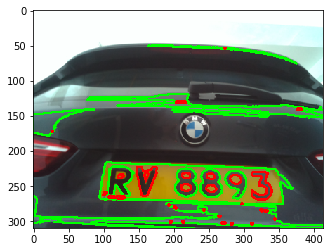

In [56]:
filtered_contours = {}
for i, h in enumerate(hierarchy[0]):
    if h[2] == -1 and h[3] != -1:
        parent_contour_index = h[3]
        child_contour = contours[i]
        if parent_contour_index in filtered_contours:
            filtered_contours[parent_contour_index].append(child_contour)
        else:
            filtered_contours[parent_contour_index] = [child_contour]

src_contour = src.copy()
parent_contours = [contours[i] for i in filtered_contours.keys()]
cv2.drawContours(src_contour, parent_contours, -1, (0,255,0), 2)
cv2.drawContours(src_contour, reduce(add, filtered_contours.values()), -1, (255,0,0), 2)
plt.imshow(src_contour, cmap = 'gray')
plt.show()

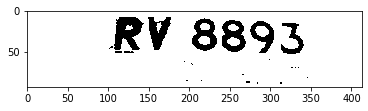

RY8893


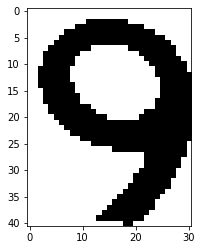

9


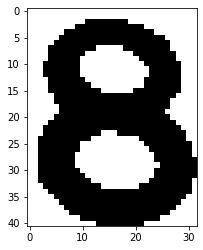

5


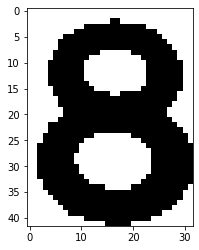

S


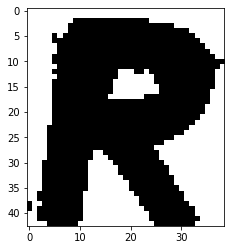

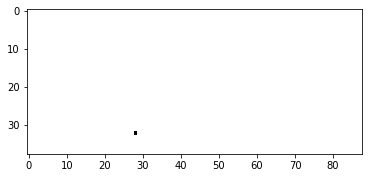

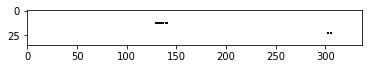

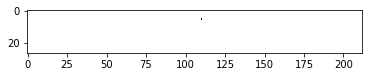

In [57]:
for contour in parent_contours:
    x,y,w,h = cv2.boundingRect(contour)
    cropped_image = binary_image_white_filled[y:y+h, x:x+w]
    plt.imshow(cropped_image, cmap='gray')
    plt.show()
    print(pytesseract.image_to_string(cropped_image, lang='eng', config='--psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'))